<a href="https://colab.research.google.com/github/SriVG17/Spotify_Recommendation_System/blob/main/Spotify_recommmendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spotipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 7.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import json
import re
import sys
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/Spotify_recommendation_system.csv')
print(data.head())
print(data.info())

   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.803  0.6240    7    -6.764     0       0.0477         0.451   
1         0.762  0.7030   10    -7.951     0       0.3060         0.206   
2         0.261  0.0149    1   -27.528     1       0.0419         0.992   
3         0.722  0.7360    3    -6.994     0       0.0585         0.431   
4         0.787  0.5720    1    -7.516     1       0.2220         0.145   

   instrumentalness  liveness  valence    tempo  duration_ms  time_signature  \
0          0.000734    0.1000   0.6280   95.968       304524               4   
1          0.000000    0.0912   0.5190  151.329       247178               4   
2          0.897000    0.1020   0.0382   75.296       286987               4   
3          0.000001    0.1230   0.5820   89.860       208920               4   
4          0.000000    0.0753   0.6470  155.117       179413               4   

   liked  
0      0  
1      1  
2      0  
3      1  
4      1  
<c

# **DATA PREPROCESSING**

In [ ]:
# Convert 'liked' column to categorical labels
data['liked'] = data['liked'].apply(lambda x: 'liked' if x == 1 else 'dislike')

# Handle missing values (if any)
data = data.dropna()

# **TF-IDF used for textual feature extraction.**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Selecting only numerical features for recommendation
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])


# To ensure all features contribute equally to the similarity score, we can scale them using

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate similarity matrix
similarity_matrix = cosine_similarity(data[features])

# Convert to DataFrame for easier readability
similarity_df = pd.DataFrame(similarity_matrix, index=data.index, columns=data.index)

In [ ]:
def recommend_songs(song_index, num_recommendations=5):
    # Get similarity scores for the song
    similarity_scores = list(enumerate(similarity_matrix[song_index]))

    # Sort songs based on similarity score, excluding the song itself
    sorted_songs = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[1:num_recommendations+1]

    # Display recommended songs
    recommended_songs = [data.iloc[i[0]]['key'] for i in sorted_songs]  # Adjust 'title' to the appropriate column
    return recommended_songs

# Example: Recommend 5 songs similar to the song at index 0
print(recommend_songs(0, 5))


[3, 7, 11, 7, 9]


In [ ]:
# Filter out songs based on user preference
liked_songs = data[data['liked'] == 'liked']

# Re-calculate similarity based on liked songs
liked_similarity_matrix = cosine_similarity(liked_songs[features])


In [ ]:
!pip install networkx

In [ ]:
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Set similarity threshold for creating edges
similarity_threshold = 0.8  # Adjust this threshold as needed

# Initialize an undirected graph
G = nx.Graph()

# Add nodes to the graph
for index, row in data.iterrows():
    G.add_node(index, title=row['mode'], liked=row['liked'])

# Add edges based on similarity
for i in range(len(similarity_matrix)):
    for j in range(i + 1, len(similarity_matrix)):
        if similarity_matrix[i, j] > similarity_threshold:
            G.add_edge(i, j, weight=similarity_matrix[i, j])

# Check the number of nodes and edges to understand the density
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")


Number of nodes: 195
Number of edges: 11247


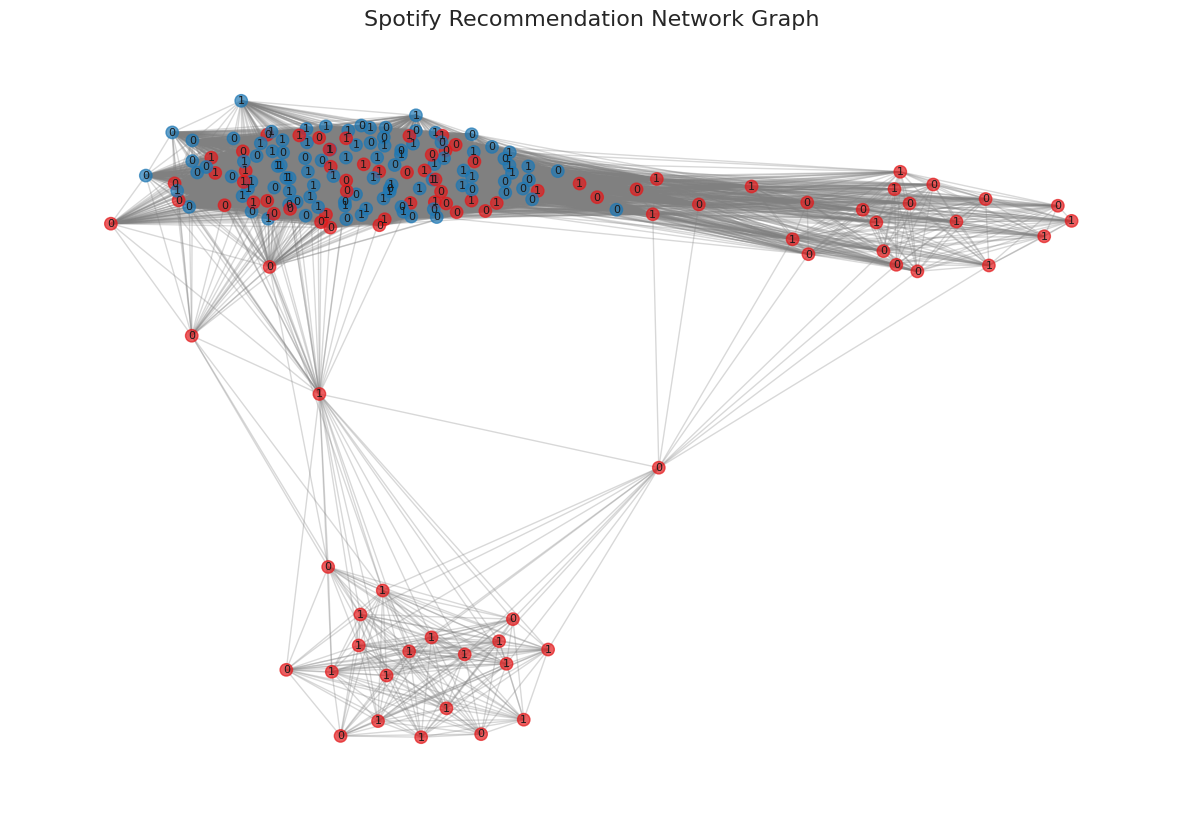

In [ ]:
# Set Seaborn style
sns.set(style="whitegrid")

# Define color mapping for 'liked' status
node_colors = ['#1f78b4' if data.loc[node]['liked'] == 'liked' else '#e31a1c' for node in G.nodes()]

# Draw the network
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=0.1, seed=42)  # Layout for a better visualization

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=80, node_color=node_colors, alpha=0.7)

# Draw edges
edges = nx.draw_networkx_edges(
    G, pos, alpha=0.3, edge_color='gray'
)

# Add labels (song titles)
nx.draw_networkx_labels(G, pos, labels={i: data.loc[i]['mode'] for i in G.nodes()}, font_size=8)

# Set plot title
plt.title("Spotify Recommendation Network Graph", fontsize=16)
plt.axis('off')  # Turn off the axis
plt.show()


In [ ]:
# Select the relevant audio features
features = ['danceability', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'speechiness', 'valence']

# Calculate the mean of each feature
feature_means = data[features].mean()


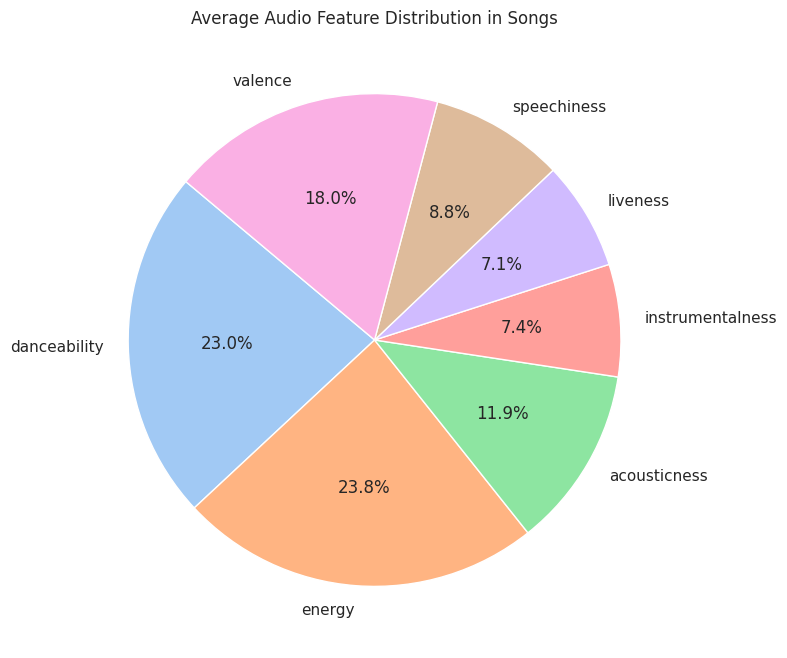

In [ ]:
# Set Seaborn style
sns.set(style="whitegrid")

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    feature_means,
    labels=feature_means.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette("pastel")
)

plt.title("Average Audio Feature Distribution in Songs")
plt.show()


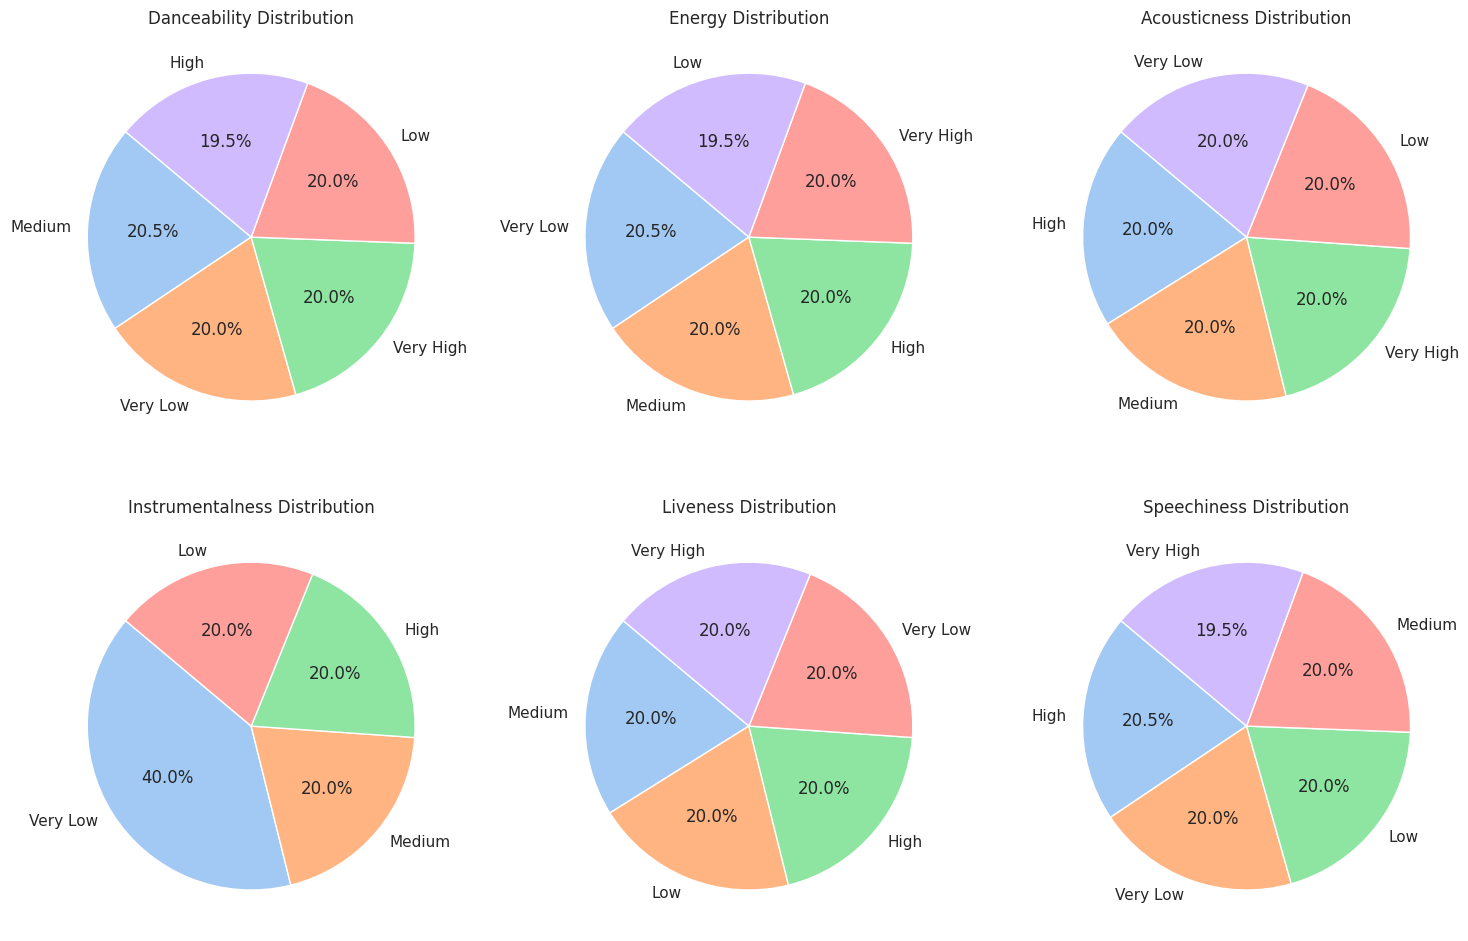

In [ ]:
# Plot individual pie charts for each feature
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()

for i, feature in enumerate(features[:6]):  # Plot only the first 6 features
    # Calculate quantiles and adjust labels if necessary
    quartiles, bins = pd.qcut(data[feature], 5, retbins=True, labels=False, duplicates='drop')  # Get quantile numbers (0 to nbins-1)
    num_bins = len(bins) - 1  # Actual number of bins after duplicate removal

    # Adjust labels to match the number of bins
    labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High'][:num_bins]
    quartiles = pd.Series(labels)[quartiles.astype(int)] # Assign labels based on quantile numbers

    quartile_counts = quartiles.value_counts()

    # Plot the pie chart for each feature
    axs[i].pie(
        quartile_counts,
        labels=quartile_counts.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=sns.color_palette("pastel")
    )
    axs[i].set_title(f"{feature.capitalize()} Distribution")

plt.tight_layout()
plt.show()